In [1]:
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../../")

from src import Netlist, LumpedElement, Resistor, Inductor, Capacitor, VoltageSource, WDFScheme
from scipy.signal import freqz
from pathlib import Path

In [2]:
class ImpulseResponse:
    def __init__(self, samplerate: int, impulse_response: np.ndarray | list[float]) -> None:
        w, h = freqz(impulse_response, 1, 2**16)
        self._samplerate: int = samplerate
        self._wdf_gains: np.ndarray = 20 * np.log10(np.abs(h))
        self._wdf_frequency: np.ndarray = w / (2 * np.pi) * samplerate
    
    def add_spice(self, spice_data: Path) -> 'ImpulseResponse':
        with spice_data.open("r") as file:
            data = json.load(file)
            self._spice_gains = data["gains"]
            self._spice_frequency = data["freqs"]
        return self
        
    def show(self, min_freq: int, max_freq: int, min_gain: int, max_gain: int) -> None:
        plt.figure(figsize=(12, 4))
        plt.grid()
        if max_freq is None:
            max_freq = self._samplerate // 2
        plt.semilogx(self._wdf_frequency, self._wdf_gains, label="WDF")
        plt.semilogx(self._spice_frequency, self._spice_gains, label="SPICE", linestyle="dashed")
        plt.xlim(min_freq, max_freq)
        plt.ylim(min_gain, max_gain)
        plt.title("Impulse response of the analog filter")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Magnitude [dB]")
        plt.legend()
        plt.show()

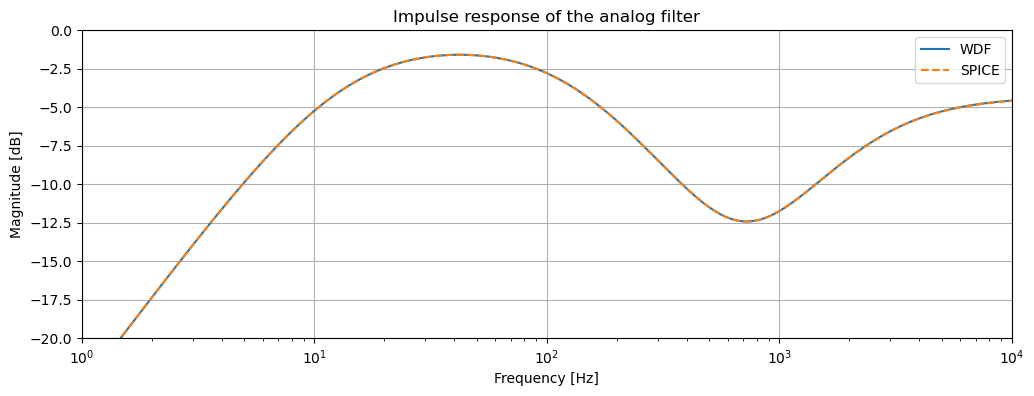

In [3]:
# bassman tone stack
bassman: Netlist = Netlist(
    LumpedElement("v_in", VoltageSource(1e-3), (0, 7)),
    LumpedElement("c1", Capacitor(0.25e-9), (0, 1)),
    LumpedElement("r1", Resistor(125e3), (1, 2)),
    LumpedElement("r2", Resistor(125e3), (2, 4)),
    LumpedElement("r3", Resistor(56e3), (0, 3)),
    LumpedElement("c2", Capacitor(20e-9), (3, 4)),
    LumpedElement("c3", Capacitor(20e-9), (3, 6)),
    LumpedElement("r4", Resistor(0.5e6), (4, 5)),
    LumpedElement("r5", Resistor(12.5e3), (5, 6)),
    LumpedElement("r6", Resistor(12.5e3), (6, 7))
)

samplerate: int = 100000
wdf: WDFScheme = WDFScheme(samplerate, bassman, outputs=[(2, 7)])
# Dirac delta function
delta: list = [1.0] + [0] * 20000
impulse_response: np.ndarray = wdf.process_signal({"v_in": delta})[0]
ImpulseResponse(samplerate, impulse_response).add_spice(Path("./spice/bassman.json")).show(1, 10000, -20, 0)

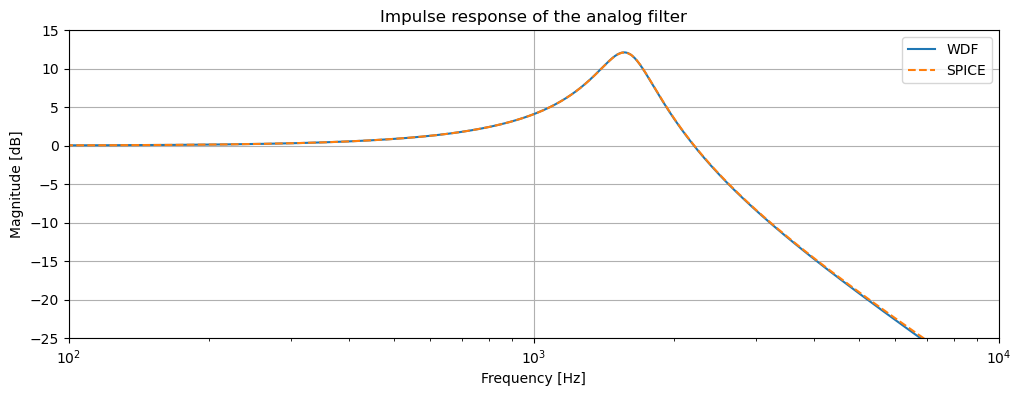

In [4]:
# double-pole RLC lowpass with Q=4
lowpass: Netlist = Netlist(
    LumpedElement("v_in", VoltageSource(1e-3), (0, 1)),
    LumpedElement("r1", Resistor(25), (0, 2)),
    LumpedElement("i1", Inductor(10e-3), (2, 3)),
    LumpedElement("c1", Capacitor(1e-6), (3, 1))
)

samplerate: int = 100000
wdf: WDFScheme = WDFScheme(samplerate, lowpass, outputs=[(3, 1)])
# Dirac delta function
delta: list = [1.0] + [0] * 20000
impulse_response: np.ndarray = wdf.process_signal({"v_in": delta})[0]
ImpulseResponse(samplerate, impulse_response).add_spice(Path("./spice/rlc_lowpass.json")).show(100, 10000, -25, 15)

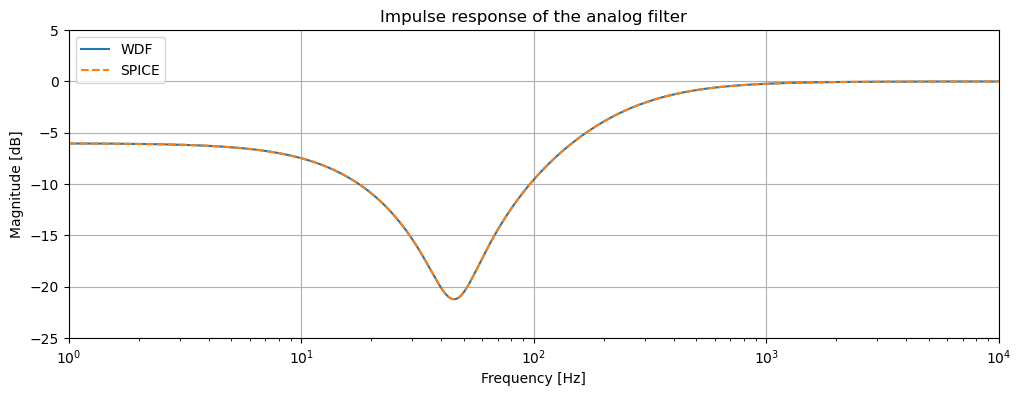

In [5]:
# bridged-T bandstop
bandstop: Netlist = Netlist(
    LumpedElement("v_in", VoltageSource(1e-3), (0, 1)),
    LumpedElement("r1", Resistor(53.8e3), (0, 2)),
    LumpedElement("r2", Resistor(1e6), (1, 3)),
    LumpedElement("c1", Capacitor(15e-9), (1, 2)),
    LumpedElement("c2", Capacitor(15e-9), (2, 3)),
    LumpedElement("r3", Resistor(1e6), (0, 3))
)

samplerate: int = 100000
wdf: WDFScheme = WDFScheme(samplerate, bandstop, outputs=[(0, 3)])
# Dirac delta function
delta: list = [1.0] + [0] * 20000
impulse_response: np.ndarray = wdf.process_signal({"v_in": delta})[0]
ImpulseResponse(samplerate, impulse_response).add_spice(Path("./spice/bridgedt_bandstop.json")).show(1, 10000, -25, 5)